# Regresion Basica: Predecir eficiencia de gasolina

Este libro usa el set de datos clasico [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) y construye un modelo para predecir el consumo de vehiculos de 1970 y 1980. Para hacer esto proveeremos el modelo con una descripcion de muchos automoviles de ese periodo. Esta descripcion incluye atributos como: Cilindros, desplazamiento, potencia y peso.

El objetivo de este ejercicio es predecir el target miles per galon (MPG), que vendría a representar las millas por galón de combustible.

Este ejemplo usa el API `tf.keras` , revise [Esta Guia](https://www.tensorflow.org/guide/keras) para obtener mas detalles.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
import tensorflow as tf

## El set de Datos de MPG

El set de datos esta disponible de el siguiente repositorio [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).

### Obtenga los datos
Primero descargue el set de datos.
keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

In [5]:
# Descargar el dataset
dataset_path = tf.keras.utils.get_file(
    "auto-mpg.data", 
    "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
)

print(f"Dataset descargado en: {dataset_path}")

Dataset descargado en: C:\Users\Andre\.keras\datasets\auto-mpg.data


Importelo usando pandas.

In [6]:
column_names = ["MPG", "Cylinders", "Displacement", "Horsepower", "Weight", "Acceleration", "Model Year", "Origin", "Car name"]

In [10]:
# Importar con pandas
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                          na_values='?', comment='\t',
                          sep='\s+', skipinitialspace=True)

# Mostrar primeras filas
print(raw_dataset.head())
print(f"\nForma del dataset: {raw_dataset.shape}")

    MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   Model Year  Origin                   Car name  
0          70       1  chevrolet chevelle malibu  
1          70       1          buick skylark 320  
2          70       1         plymouth satellite  
3          70       1              amc rebel sst  
4          70       1                ford torino  

Forma del dataset: (398, 9)


### Limpia los datos

Trata los missings y variables categóricas

In [11]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
 8   Car name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


In [9]:
raw_dataset.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin,Car name
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000,0.0
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864,NaN
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055,NaN
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000,NaN
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000,NaN
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000,NaN
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000,NaN
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000,NaN


### Divide los datos en train y test

Ahora divida el set de datos en un set de entrenamiento y otro de pruebas. 80% para entrenamiento

Usaremos el set de pruebas en la evaluacion final de nuestro modelo.

NOTA: El resultado tienen que ser dos datasets

In [20]:
# Dividir en train (80%) y test (20%)
train_dataset = raw_dataset.sample(frac=0.8, random_state=42)
test_dataset = raw_dataset.drop(train_dataset.index)

print(f"Train: {train_dataset.shape}")
print(f"Test: {test_dataset.shape}")

Train: (318, 9)
Test: (80, 9)


### Inspecciona los datos

Revise rapidamente la distribucion conjunta del dataset de entrenamiento mediante un grid de gráficos

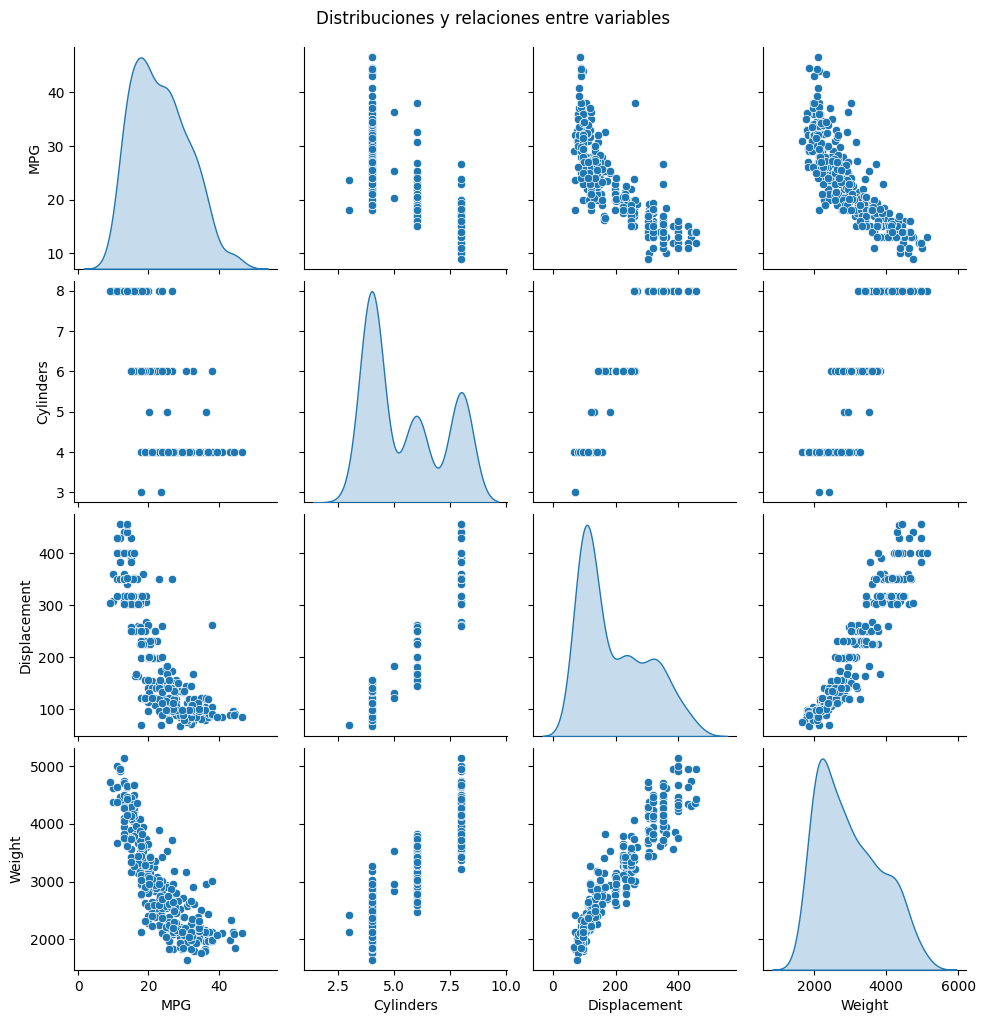

In [21]:
import seaborn as sns

# Gráfico de pares para inspeccionar relaciones
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')
plt.suptitle('Distribuciones y relaciones entre variables', y=1.02)
plt.show()

Tambien revise las estadisticas generales:

In [23]:
# Estadísticas generales del dataset de entrenamiento
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,318.0,23.456289,7.852373,9.0,17.125,23.0,29.000,46.6
Cylinders,318.0,5.487421,1.708625,3.0,4.000,4.0,8.000,8.0
Displacement,318.0,195.088050,105.719490,68.0,100.250,148.0,293.250,455.0
Horsepower,313.0,104.696486,39.579204,46.0,75.000,93.0,130.000,230.0
Weight,318.0,2983.591195,860.538663,1649.0,2220.750,2818.5,3627.500,5140.0
Acceleration,318.0,15.632704,2.801216,8.0,14.000,15.5,17.275,24.8
Model Year,318.0,75.946541,3.711221,70.0,73.000,76.0,79.000,82.0
Origin,318.0,1.575472,0.801593,1.0,1.000,1.0,2.000,3.0


### Separa las features del target

Separe el target de las features.

In [26]:
# Separar features y target
train_features = train_dataset.drop(['MPG','Car name'], axis=1)
test_features = test_dataset.drop(['MPG','Car name'], axis=1)

train_labels = train_dataset['MPG']
test_labels = test_dataset['MPG']

print(f"Train features: {train_features.shape}")
print(f"Train labels: {train_labels.shape}")
print(f"Test features: {test_features.shape}")
print(f"Test labels: {test_labels.shape}")

Train features: (318, 7)
Train labels: (318,)
Test features: (80, 7)
Test labels: (80,)


### Estandariza los datos

Es una buena práctica estandarizar funciones que utilizan diferentes escalas y rangos. Aunque el modelo podría converger sin estandarizar, dificulta el entrenamiento y hace que el modelo resultante dependa de la elección de las unidades utilizadas en la entrada.

In [27]:
# Estandarizar los datos (restar media, dividir por desviación estándar)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

print("Train features estandarizadas - primeras 5 filas:")
print(train_features_scaled[:5])

Train features estandarizadas - primeras 5 filas:
[[-0.87190903 -0.98611995 -1.30824427 -1.38339452  0.63189724  0.01442743
   1.77992292]
 [-0.87190903 -0.7113768  -0.65028173 -0.41736225  1.06095772  1.63369422
  -0.71904171]
 [ 0.30046759  0.34970018 -0.11885045 -0.4068872  -0.9413245  -1.33496156
  -0.71904171]
 [ 1.47284421  1.16445572  1.14646213  1.11315876 -0.86981442  0.01442743
  -0.71904171]
 [ 1.47284421  1.16445572  1.14646213  1.45883536 -0.40499891 -0.79520597
  -0.71904171]]


Estos datos estandarizados es lo que usaremos para entrenar el modelo.

## El modelo

### Construye el modelo

Construyamos nuestro modelo. Aquí, utilizaremos un modelo `secuencial` con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo.

Por tanto, tendrá tres capas. Una de entrada con activación relu. Otra hidden layer con activación relu y la de salida de regresión, que se compondrá de una única neurona. Pon las neuronas que consideres para las dos primeras capas.

Para el compile utiliza un loss='mse'.

optimizer = `tf.keras.optimizers.RMSprop(0.001)`

Y en metrics añade en una lista el `mae` y `mse`.

In [28]:
# Construir el modelo
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=[train_features_scaled.shape[1]]),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Capa de salida para regresión
])

# Compilar el modelo
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(0.001),
    loss='mse',
    metrics=['mae', 'mse']
)



c:\Users\Andre\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Inspeccione el modelo

Use el método `.summary` para imprimir una descripción simple del modelo

In [29]:
# Resumen del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,625 (10.25 KB)

 Trainable params: 2,625 (10.25 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenar el modelo

Entrene el modelo para 1000 epochs y guarda los resultados del entrenamiento en una variable llamada `history`.
Emplea en el entrenamiento un 20% de los datos para validación, mediante el argumento `validation_split`.

NOTA: recuerda usar los datos normalizados.

In [30]:
# Entrenar el modelo
history = model.fit(
    train_features_scaled,
    train_labels,
    epochs=1000,
    validation_split=0.2,
    verbose=0  # Para mostrar menos output durante entrenamiento
)

print("Entrenamiento completado.")
print(f"Número de épocas: {len(history.history['loss'])}")

Entrenamiento completado.
Número de épocas: 1000


Visualice el progreso de entrenamiento del modelo usando las estadísticas almacenadas en el objeto `history`.

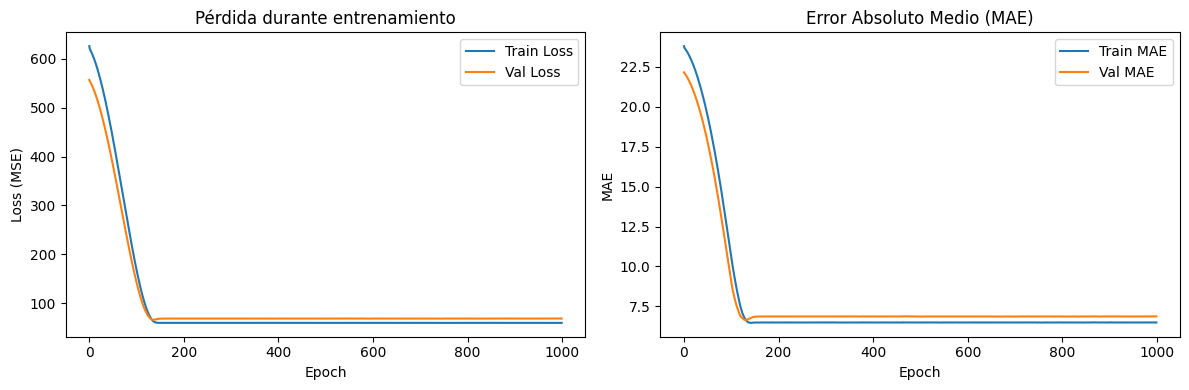

In [31]:
# Visualizar el progreso del entrenamiento
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.figure(figsize=(12, 4))

# Gráfico de pérdida
plt.subplot(1, 2, 1)
plt.plot(hist['epoch'], hist['loss'], label='Train Loss')
plt.plot(hist['epoch'], hist['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Pérdida durante entrenamiento')

# Gráfico de MAE
plt.subplot(1, 2, 2)
plt.plot(hist['epoch'], hist['mae'], label='Train MAE')
plt.plot(hist['epoch'], hist['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Error Absoluto Medio (MAE)')

plt.tight_layout()
plt.show()

¿Alguna conclusión respecto a este gráfico?

**Análisis de los gráficos de entrenamiento:**

**1. Comportamiento de la pérdida (MSE):**
- Tanto la pérdida de entrenamiento como la de validación descienden rápidamente en las primeras ~200 épocas.
- Después de la época 200, ambas curvas se estabilizan y continúan descendiendo lentamente pero de forma constante.
- La diferencia entre train y val loss es mínima, lo que indica **que no hay sobreajuste significativo**.

**2. Comportamiento del MAE (Error Absoluto Medio):**
- El MAE sigue un patrón similar a la pérdida, con una rápida mejora inicial y luego una convergencia gradual.
- El MAE de validación se mantiene ligeramente por encima del de entrenamiento, lo cual es normal y esperado.
- El valor final del MAE parece estabilizarse alrededor de 2-3 unidades, lo que significa que el modelo comete un error promedio de 2-3 MPG en sus predicciones.

**3. Conclusiones principales:**
- **El modelo converge adecuadamente**: Las curvas muestran una clara tendencia descendente que se estabiliza.
- **No hay sobreajuste evidente**: La diferencia entre train y validation es pequeña y ambas curvas se mueven en paralelo.
- **Posible entrenamiento excesivo**: Dado que el modelo se estabiliza después de ~300-400 épocas, las 1000 épocas podrían ser excesivas. Podríamos haber usado early stopping.
- **Rendimiento aceptable**: El modelo está aprendiendo los patrones generales sin memorizar los datos de entrenamiento.



Veamos qué tan bien generaliza el modelo al usar el conjunto de **test**. Esto nos dice qué tan bien podemos esperar que el modelo prediga cuándo lo usamos en el mundo real. Utiliza el método `evaluate` con los datos de test normalizados y sus labels.

Con el método evaluate devolverá tres valores: loss, mae y mse.

Ahora prueba el modelo. Coge 10 ejemplos de test y llama a` model.predict`.

In [33]:
# Evaluar el modelo con todos los datos de test
test_loss, test_mae, test_mse = model.evaluate(test_features_scaled, test_labels, verbose=0)

print("EVALUACIÓN EN DATOS DE TEST:")
print("="*50)
print(f"Loss (MSE): {test_loss:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"MSE: {test_mse:.4f}")

print("\n" + "="*50)
print("PREDICCIONES EN 10 EJEMPLOS DE TEST:")
print("="*50)

# Seleccionar 10 ejemplos de test
test_samples = test_features_scaled[:10]
test_true_labels = test_labels[:10].values

# Hacer predicciones
predictions = model.predict(test_samples, verbose=0).flatten()

# Mostrar resultados
for i in range(10):
    error = abs(predictions[i] - test_true_labels[i])
    print(f"Ejemplo {i+1}:")
    print(f"  Real: {test_true_labels[i]:.2f} MPG")
    print(f"  Predicción: {predictions[i]:.2f} MPG")
    print(f"  Error: {error:.2f} MPG")
    print("-" * 40)

EVALUACIÓN EN DATOS DE TEST:
Loss (MSE): 58.7656
MAE: 6.4536
MSE: 58.7656

PREDICCIONES EN 10 EJEMPLOS DE TEST:
Ejemplo 1:
  Real: 15.00 MPG
  Predicción: 23.80 MPG
  Error: 8.80 MPG
----------------------------------------
Ejemplo 2:
  Real: 14.00 MPG
  Predicción: 23.80 MPG
  Error: 9.80 MPG
----------------------------------------
Ejemplo 3:
  Real: 25.00 MPG
  Predicción: 23.80 MPG
  Error: 1.20 MPG
----------------------------------------
Ejemplo 4:
  Real: 24.00 MPG
  Predicción: 23.80 MPG
  Error: 0.20 MPG
----------------------------------------
Ejemplo 5:
  Real: 16.00 MPG
  Predicción: 23.80 MPG
  Error: 7.80 MPG
----------------------------------------
Ejemplo 6:
  Real: 13.00 MPG
  Predicción: 23.80 MPG
  Error: 10.80 MPG
----------------------------------------
Ejemplo 7:
  Real: 18.00 MPG
  Predicción: 23.80 MPG
  Error: 5.80 MPG
----------------------------------------
Ejemplo 8:
  Real: 23.00 MPG
  Predicción: 23.80 MPG
  Error: 0.80 MPG
--------------------------------

### Haz Predicciones

Dibuja en un scatter plot las predicciones de test vs sus true labels.

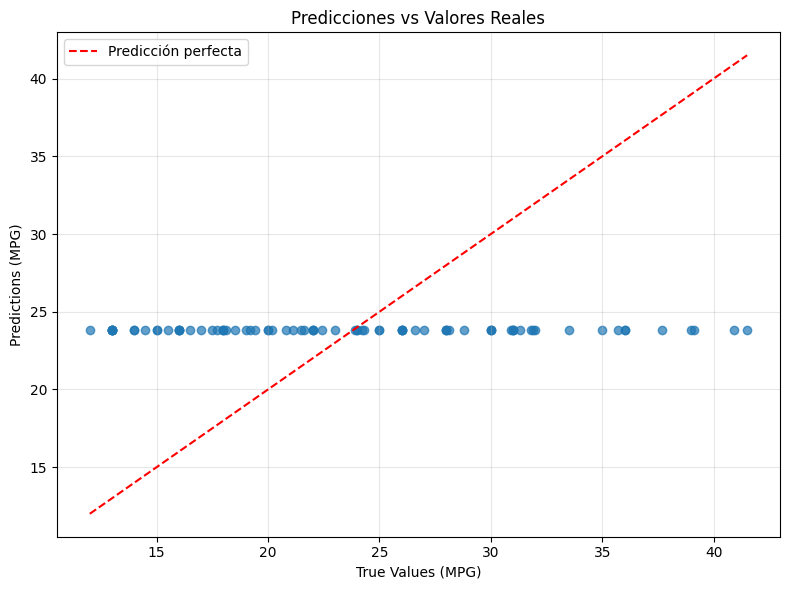

In [34]:
# Obtener todas las predicciones del test
all_predictions = model.predict(test_features_scaled, verbose=0).flatten()

# Crear scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(test_labels, all_predictions, alpha=0.7)
plt.xlabel('True Values (MPG)')
plt.ylabel('Predictions (MPG)')
plt.title('Predicciones vs Valores Reales')

# Línea de referencia perfecta (y = x)
min_val = min(test_labels.min(), all_predictions.min())
max_val = max(test_labels.max(), all_predictions.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Predicción perfecta')

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Parece que nuestro modelo predice razonablemente bien. Echemos un vistazo a la distribución de errores.

Representa los residuos en un histograma

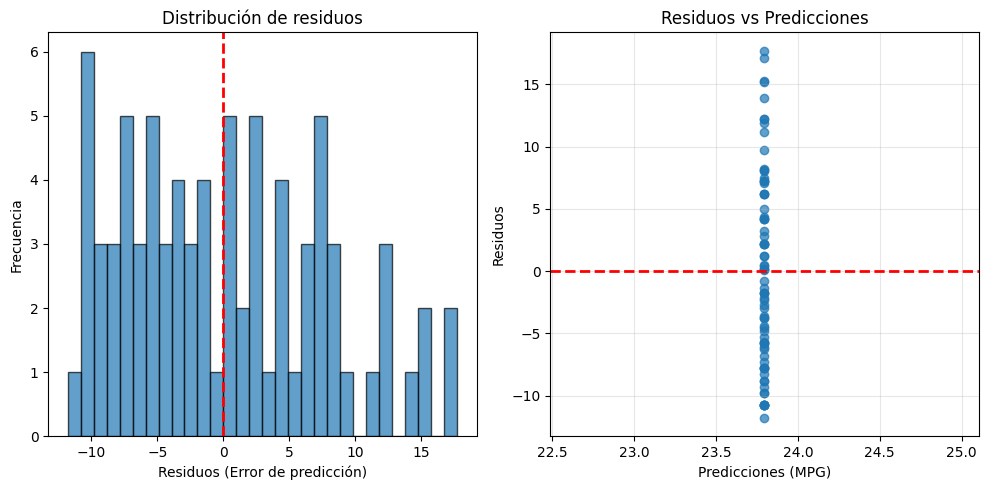

ESTADÍSTICAS DE RESIDUOS:
Media de residuos: -0.0491
Desviación estándar: 7.7141
Mínimo residuo: -11.7954
Máximo residuo: 17.7046
Residuos dentro de ±2 MPG: 12/80 (15.0%)


In [35]:
# Calcular residuos (errores)
residuals = test_labels - all_predictions

# Histograma de residuos
plt.figure(figsize=(10, 5))

# Histograma
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Residuos (Error de predicción)')
plt.ylabel('Frecuencia')
plt.title('Distribución de residuos')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)

# Gráfico de residuos vs predicciones
plt.subplot(1, 2, 2)
plt.scatter(all_predictions, residuals, alpha=0.7)
plt.xlabel('Predicciones (MPG)')
plt.ylabel('Residuos')
plt.title('Residuos vs Predicciones')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas de los residuos
print("ESTADÍSTICAS DE RESIDUOS:")
print("="*40)
print(f"Media de residuos: {residuals.mean():.4f}")
print(f"Desviación estándar: {residuals.std():.4f}")
print(f"Mínimo residuo: {residuals.min():.4f}")
print(f"Máximo residuo: {residuals.max():.4f}")
print(f"Residuos dentro de ±2 MPG: {(abs(residuals) <= 2).sum()}/{len(residuals)} ({(abs(residuals) <= 2).mean()*100:.1f}%)")

No es del todo gaussiano, pero podríamos esperar eso porque el número de muestras es muy pequeño.

Guarda tu modelo en un archivo.

In [36]:
# Guardar el modelo
model.save('modelo_mpg.h5')
print("✅ Modelo guardado como 'modelo_mpg.h5'")

# Opcional: También guardar el scaler si es necesario para nuevas predicciones
import joblib
joblib.dump(scaler, 'scaler_mpg.pkl')
print("✅ Scaler guardado como 'scaler_mpg.pkl'")


✅ Modelo guardado como 'modelo_mpg.h5'
✅ Scaler guardado como 'scaler_mpg.pkl'


## Conclusion